# Bulk Labelling Multimodal Data


In this tutorial, we will work with multimodal data of images and text. It will walk you through the following steps:

- Load a dataset with images and text of electronic products.
- Experiment with zero shot image and text classification.
- Label the data using the bulk labelling with image and text embeddings.
- Train a SetFit classification model on the labelled data.

<img src="../../_static/tutorials/labelling-textclassification-image-bulk-labelling/argilla_image_cables.png" alt="Argilla with images tutorial" style="width: 1100px;">


## Introduction

__Real world multimodal data__ is often a mix of text and images. In this tutorial, we will work with a dataset of electronic products. The dataset contains images of the products and a description of the product. 

This notebook uses a dataset of electronics parts and products from a fictional electronics web shop. 

Let's get started!

In [2]:
%pip install argilla "setfit~=0.2.0" "datasets~=2.3.0" transformers sentence-transformers -qqq

Let's import the Argilla module for reading and writing data:

In [3]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [4]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="https://localhost:6900",
    api_key="team.apikey"
)

Finally, let's include the imports we need:

In [5]:
from requests import get

from datasets import load_dataset
from PIL import Image
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
from PIL import Image

## Running (Forked) Argilla with image hack

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

1. [Deploy Argilla on Hugging Face Spaces](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla): This is the fastest option and the recommended choice for connecting to external notebooks (e.g., Google Colab) if you have an account on Hugging Face. You can deploy the image hack version of Argilla on Hugging Face Spaces by by duplicating [this space](https://huggingface.co/spaces/burtenshaw/argilla-image) . 

2. [Launch Argilla using a customised quickstart Docker image](../../getting_started/quickstart.ipynb): This is the recommended option if you want Argilla running on your local machine. The image hack version of Argilla is available on Docker Hub as `burtenshaw/argilla-image`. 

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup

For this tutorial, you'll need to install the Argilla client and a few third party libraries using `pip`:

# The Dataset: a 'real world' multimodal data

The dataset samples contain a `page_name`, `page_descriptions`, and a `label`. The dataset is split into two parts: `labelled` and `unlabelled`. The labelled portion is the result of my annotation so we can test methods. In reality, let's say this doesn't exist 😏. 

In [ ]:
ELECTRONICS_DATASET = "burtenshaw/electronics"
dataset = load_dataset(ELECTRONICS_DATASET)
labels = dataset["labelled"].features["label"].names
int2str = dataset["labelled"].features["label"].int2str
# show a sample
next(iter(dataset["labelled"]))

# 📷 Zero Shot Image Classification

First, we will explore some zero shot techniques. For the sake of comparison, we will use the `labelled` portion of the dataset.


In [ ]:
# to save time, we'll take a slice of the dataset
test_dataset = load_dataset(ELECTRONICS_DATASET, split="test[:20%]")

In [ ]:
# More models in the model hub.
model_name = "openai/clip-vit-large-patch14"
classifier = pipeline("zero-shot-image-classification", model = model_name)

First, we can zero shot classify one image from the dataset: 

{'score': 0.9631495475769043, 'label': 'switches'}


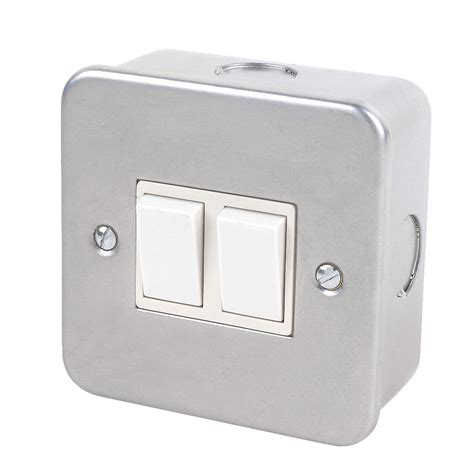

In [36]:
image_to_classify = next(iter(dataset["test"]))["image_url"]
scores = classifier(image_to_classify, candidate_labels = labels)
print(scores[0])
Image.open(get(image_to_classify, stream =True).raw)

Now we will test the accuracy and latency of a zero shot image classifier on a sub section of the `labelled` portion of the dataset.

In [39]:
%%time
def classify_image(sample):
    label = classifier(sample["image_url"], candidate_labels = labels)[0]["label"]
    sample["clip_zero_shot"] = labels.index(label)
    return sample

test_dataset = test_dataset.map(classify_image)
accuracy_score(test_dataset["label"], test_dataset["clip_zero_shot"])

  0%|          | 0/34 [00:00<?, ?ex/s]

CPU times: user 4min 52s, sys: 4.42 s, total: 4min 57s
Wall time: 2min 30s


0.8235294117647058

😞 Zero shot image classification with a CLIP model gives an accuracy of **0.82** in just under **5 minutes** for only **20%** of the test data. This score is not impressive. Let's see if the text is more reliable.

# 📚 🙈 Zero-shot text classification

The product description and name also contain valuable information. Let's see what zero shot classification of those can achieve. 

In [40]:
classifier = pipeline(model="facebook/bart-large-mnli")

In [41]:
%%time
def classify_text(sample):
    label = classifier(sample["page_description"], candidate_labels = labels)["labels"][0]
    sample["bart_zero_shot"] = labels.index(label)
    return sample

test_dataset = test_dataset.map(classify_text)
accuracy_score(test_dataset["label"], test_dataset["bart_zero_shot"])

  0%|          | 0/34 [00:00<?, ?ex/s]

CPU times: user 3min 10s, sys: 2.38 s, total: 3min 12s
Wall time: 1min 36s


0.7941176470588235

\😞 Text classification takes less time, but accuracy is also less at __.79__. This shows that some information is held in images that's not in the text. It would be great if we could consolidate this information. 🤞

Furthermore, both of these approaches use large language models that consume a significant amount of compute.

# Consolidate our data with Argilla (Multi-modal) bulk labelling 📷 ⚓ 📚

The above scores from two zero shot classification approaches scores reveal that the task is challenging using a zero shot approach. 

With (our modified) Argilla, we can re-label the dataset and combine the information from image and text. Then, we can perform few shot learning on the dataset.

## 📚 Text embeddings for bulk labelling

In [ ]:
# Define sentence transformers model for text embedding
dataset = load_dataset(ELECTRONICS_DATASET, streaming=True)
encoder = SentenceTransformer("all-MiniLM-L6-v2")

In [24]:
# Encode text field using batched computation
dataset = dataset.map(lambda batch: {"vectors": encoder.encode(batch["page_name"]).tolist()}, batch_size=32, batched=True)

# Turn vectors into a dictionary
dataset = dataset.map(
    lambda r: {"vectors": {"mini-lm-sentence-transformers": r["vectors"]}}
)

In [ ]:
# instantiate Argilla records with vectors
records = [
    rg.TextClassificationRecord(
        text=sample["page_name"],
        metadata=dict(image_path=sample["image_url"]),
        vectors=sample["vectors"]
    )
    for sample in dataset["unlabelled"]
]
dataset_rg = rg.DatasetForTextClassification(records)

# upload recors with vectors to Argilla
rg.log(
    records=dataset_rg,
    name="electronics_with_vectors",
    tags={"vectors":"text-mini-lm"}
)

## 📷 Image embeddings & bulk labelling

Now we can use a clip model to get image embeddings for the images in the dataset. We can then repeat the process in the Argilla UI to bulk label the samples based on their similar images.

In [ ]:
# Load CLIP model for image embedding
image_encoder = SentenceTransformer('clip-ViT-B-32')

In [28]:
def encode_image(image_url):
    # utility function to encode image
    img = Image.open(get(image_url, stream =True).raw)
    vector = image_encoder.encode(img).tolist()
    return vector

# Encode text field using batched computation
dataset = dataset.map(lambda sample: {"vectors": encode_image(sample["image_url"])}, batched=False)

# Turn vectors into a dictionary
dataset = dataset.map(
    lambda r: {"vectors": {"clip-ViT-B-32": r["vectors"]}}
)

In [29]:
# # Load the partially annotated dataset
# dataset_rg = dataset_rg.prepare_for_training(framework="transformers")

records = [
    rg.TextClassificationRecord(
        text=sample["page_name"],
        metadata=dict(image_path=sample["image_url"]),
        vectors=sample["vectors"]
    ) for sample in dataset["unlabelled"]
]  

dataset_rg = rg.DatasetForTextClassification(records)

# upload the records with vectors to Argilla
rg.log(
    records=dataset_rg,
    name="electronics_with_image_vectors",
    tags={"plugin": "image", "vectors":"image-clip"}
)

  0%|          | 0/252 [00:00<?, ?it/s]

252 records logged to https://burtenshaw-argilla-image.hf.space/datasets/team/electronics_with_image_vectors


BulkResponse(dataset='electronics_with_image_vectors', processed=252, failed=0)

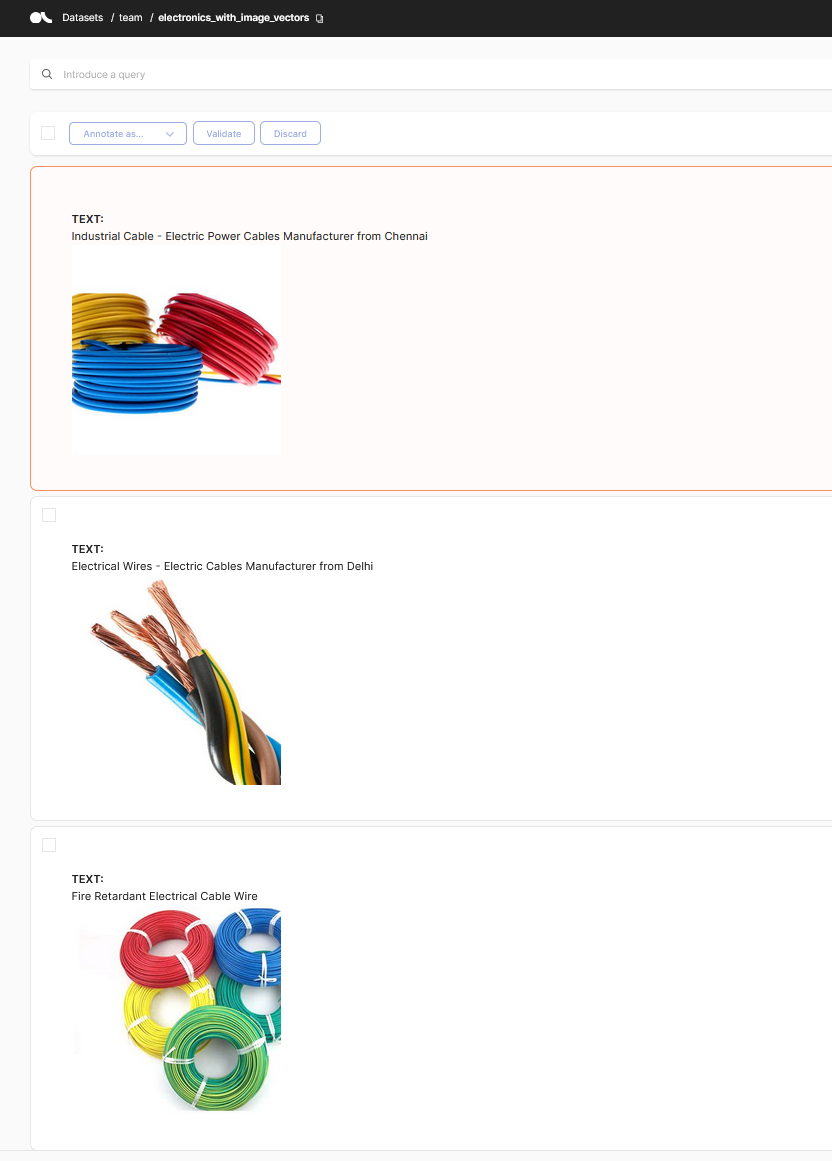

# Fewshot Classification of bulk labelled data

We can now use our newly labelled dataset to train a classifier. We will use a SetFit model due to the limited sample count. Notice the significantly reduced inference time and increased accuracy. 

In [ ]:
# load the 'newly' labelled dataset 
labelled_dataset = dataset_rg.prepare_for_training(framework="transformers")
# # To try the prelabelled slice from HF Hub
# labelled_dataset = load_dataset(ELECTRONICS_DATASET, split="labelled")
# # To evaluate on the larger test set
# test_dataset = datasets.load_dataset(ELECTRONICS_DATASET, split="test")

In [ ]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=labelled_dataset,
    eval_dataset=test_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=10,
    column_mapping={"page_name":"text", "label":"label"}
)


Now let's train ✈

In [43]:
trainer.train()
metrics = trainer.evaluate()
print(metrics)

Applying column mapping to training dataset
***** Running training *****
  Num examples = 5040
  Num epochs = 1
  Total optimization steps = 315
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/315 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.9117647058823529}


## Summary

In this tutorial, we learnt to bulk label a multi-modal dataset using a modified version of Argilla. We compared a few shot classifier trained on the bulk labelled dataset with zero shot classifiers of image and text. The results show that the few shot classifier is able to achieve a higher accuracy than the zero shot classifiers. Furthermore, the SetFit model is significantly faster than the zero shot classifiers.

This approach can be applied to classification tasks with limited data and can be used to train a classifier with minimal human effort.